In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Compute Model Parameters (Spectrogram Shape)

In [2]:
file_path = "./data/17P/test/walk_0621_0422.csv"

# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True
features = ['Q', 'omega', 'omega_l2']

spectrograms_file, gts_file, times_file = prepare_file(file_path, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 278/300
----------------------------
sepctrograms:(22, 16, 65, 3)
gt:(22, 1)
times:(22, 1)


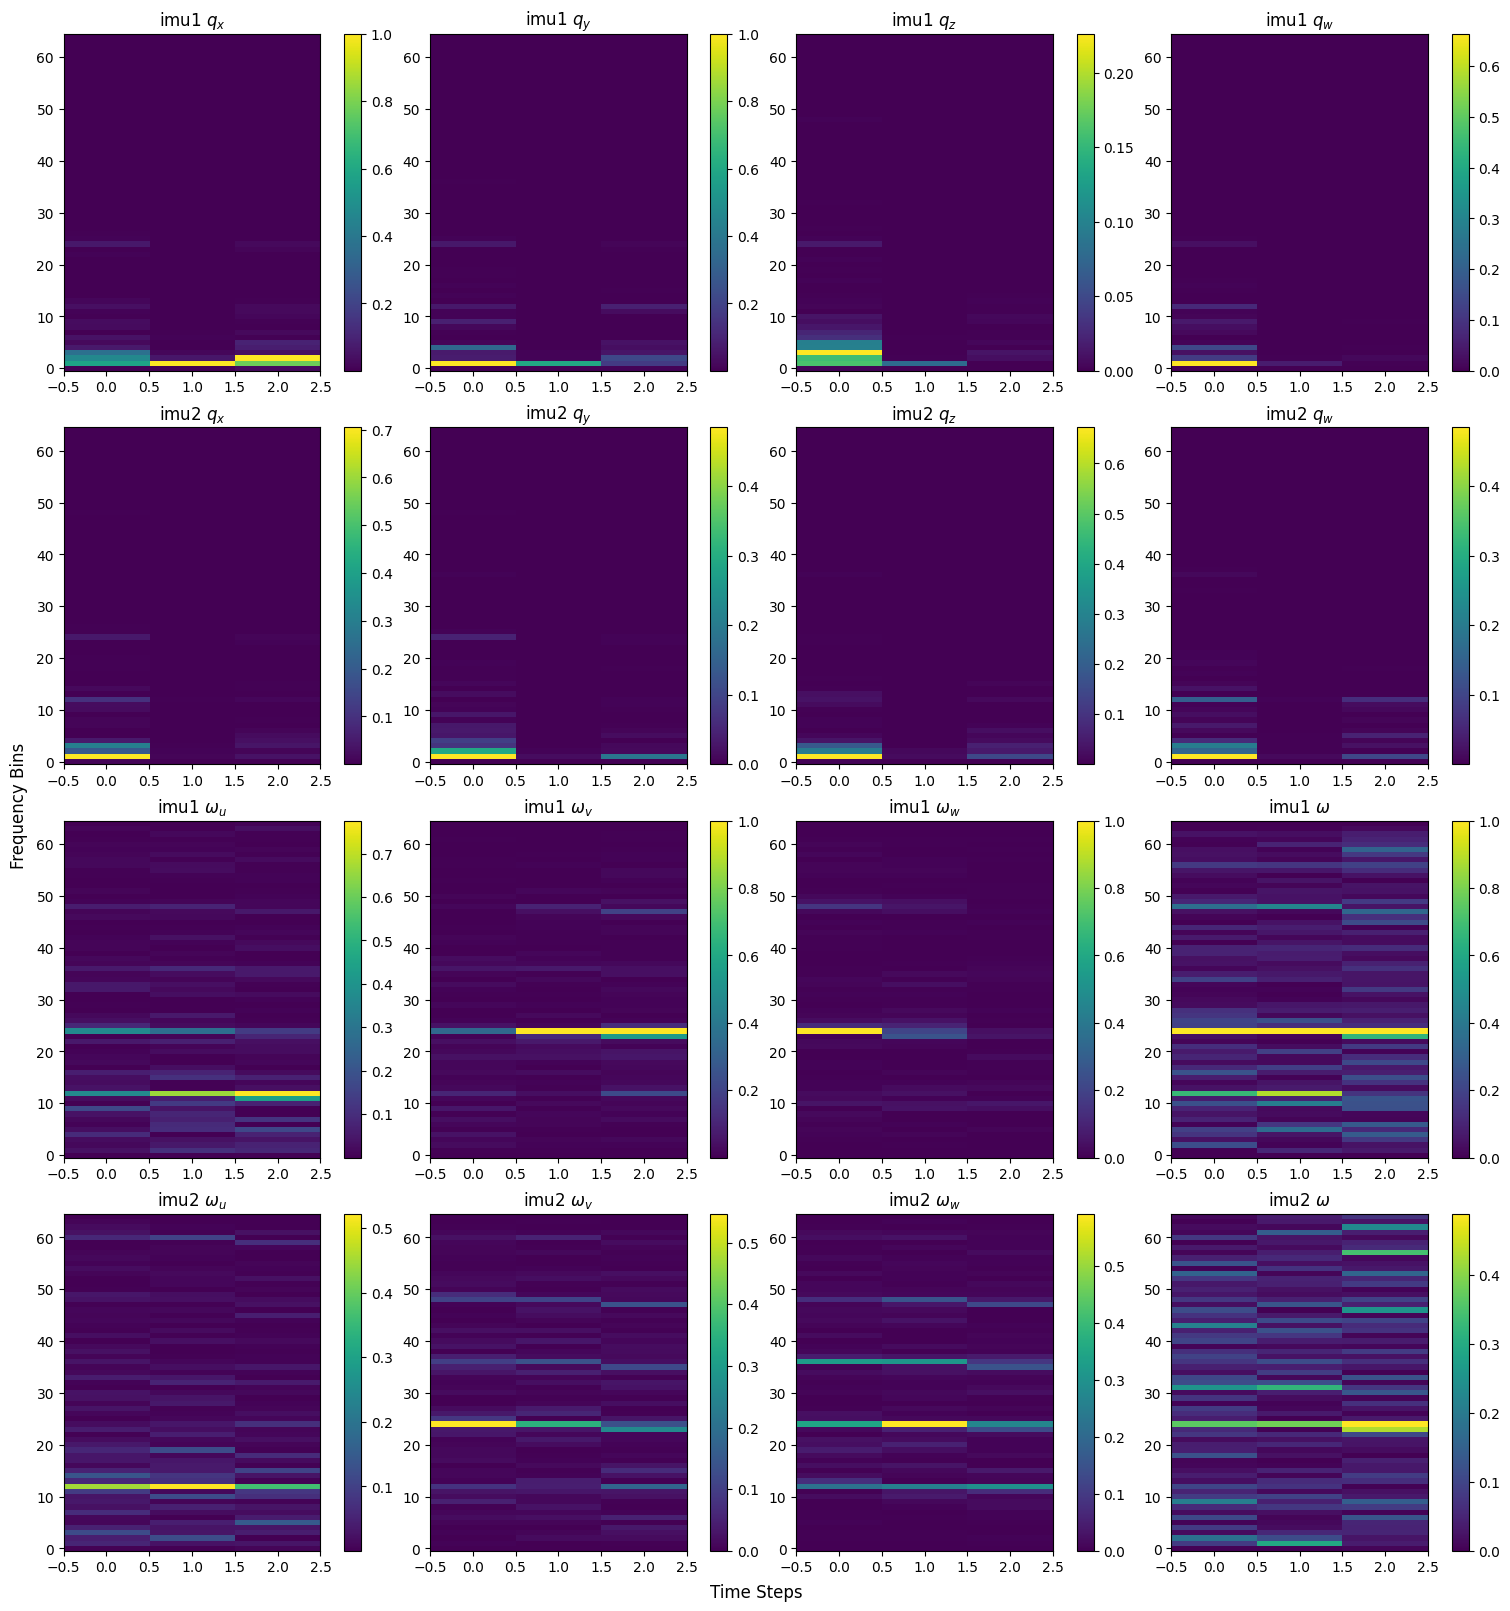

In [3]:
# show one spectrogram
plot_spectrogram(spectrograms_file[10], features=features)

In [4]:
torch.cuda.is_available()

True

## Testing Model

In [5]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "17P_16"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (458, 16, 65, 3)


In [6]:
# Test one file
action_name = 'walk_0621_0422'
path_file = f'./data/17P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 278/300
----------------------------
sepctrograms:(22, 16, 65, 3)
gt:(22, 1)
times:(22, 1)


In [7]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_17P_16', 'CNN_17P_16', 'VT_17P_16_emt2', 'VT_17P_16_emht2']
models_name_show = ["MLP", "CNN", "ViT_emt2", "ViT_emht2"]

# models_name = ['MLP_17P_16', 'CNN_17P_16', 'VT_17P_16_emt2']
# models_name_show = ["f1&2+MLP", "f1&2+CNN", "f1&2+ViT"]

# models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
#           CNN_out1_2(num_channels=num_channels),
#           VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, device=device),]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, device=device),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_17P_16 Evaluation Results - MSE Loss: 0.0063, L1 Loss: 3.0880 1/min
CNN_17P_16 Evaluation Results - MSE Loss: 0.0049, L1 Loss: 3.1164 1/min
VT_17P_16_emt2 Evaluation Results - MSE Loss: 0.0054, L1 Loss: 3.4387 1/min
VT_17P_16_emht2 Evaluation Results - MSE Loss: 0.0049, L1 Loss: 3.0583 1/min


MLP Evaluation Results - MSE Loss: 0.0079, L1 Loss: 4.2132 1/min, R²:-1.3621
CNN Evaluation Results - MSE Loss: 0.0043, L1 Loss: 2.9779 1/min, R²:-0.2828
ViT_emt2 Evaluation Results - MSE Loss: 0.0057, L1 Loss: 4.2854 1/min, R²:-0.6977
ViT_emht2 Evaluation Results - MSE Loss: 0.0039, L1 Loss: 3.2337 1/min, R²:-0.1779


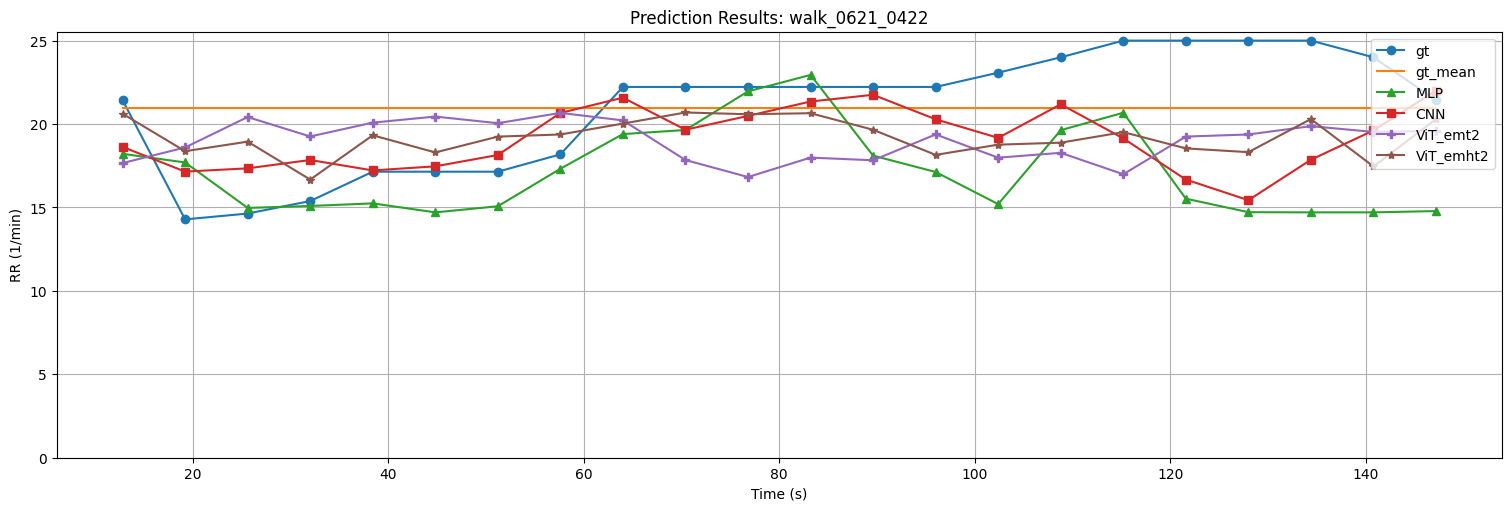

In [8]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=models_name_show, gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [9]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "17P_16"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


MLP
sit - MSE Loss: 0.0012, L1 Loss: 1.3744 1/min
stand - MSE Loss: 0.0015, L1 Loss: 1.6145 1/min
walk - MSE Loss: 0.0184, L1 Loss: 6.0626 1/min
run - MSE Loss: 0.0046, L1 Loss: 3.2675 1/min

CNN
sit - MSE Loss: 0.0019, L1 Loss: 1.8843 1/min
stand - MSE Loss: 0.0026, L1 Loss: 2.4489 1/min
walk - MSE Loss: 0.0126, L1 Loss: 5.6865 1/min
run - MSE Loss: 0.0030, L1 Loss: 2.5419 1/min

ViT_emt2
sit - MSE Loss: 0.0044, L1 Loss: 2.8523 1/min
stand - MSE Loss: 0.0028, L1 Loss: 2.7292 1/min
walk - MSE Loss: 0.0108, L1 Loss: 5.3404 1/min
run - MSE Loss: 0.0039, L1 Loss: 2.9430 1/min

ViT_emht2
sit - MSE Loss: 0.0025, L1 Loss: 2.1353 1/min
stand - MSE Loss: 0.0027, L1 Loss: 2.5093 1/min
walk - MSE Loss: 0.0120, L1 Loss: 5.3651 1/min
run - MSE Loss: 0.0027, L1 Loss: 2.3422 1/min



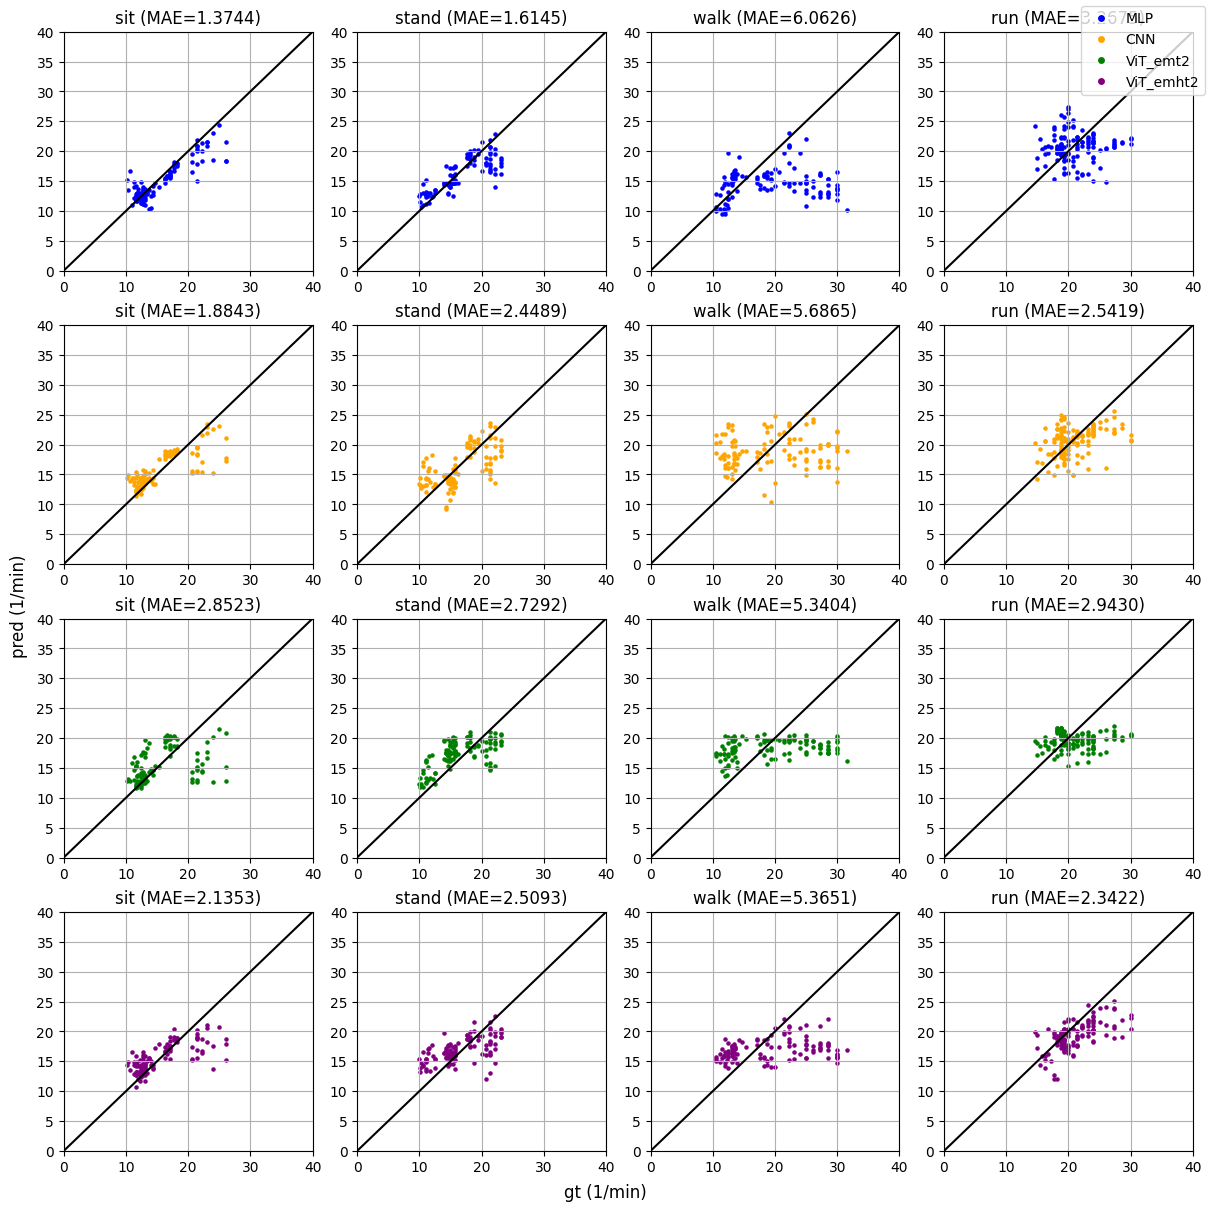

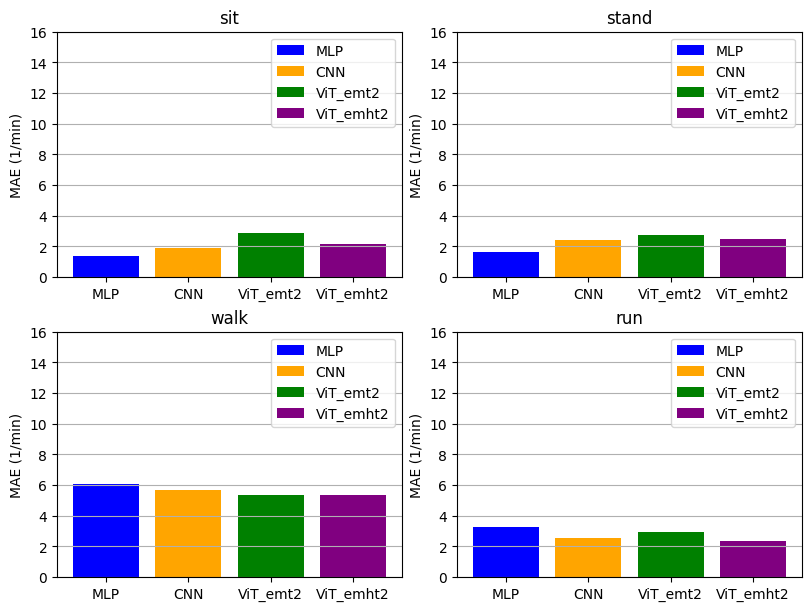

In [10]:
evaluate_models_action(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)

MLP
sit - MSE Loss: 0.0012, L1 Loss: 1.3744 1/min E%: 8.7642%
stand - MSE Loss: 0.0015, L1 Loss: 1.6145 1/min E%: 9.4914%
walk - MSE Loss: 0.0184, L1 Loss: 6.0626 1/min E%: 26.8744%
run - MSE Loss: 0.0046, L1 Loss: 3.2675 1/min E%: 15.4684%

CNN
sit - MSE Loss: 0.0019, L1 Loss: 1.8843 1/min E%: 11.9121%
stand - MSE Loss: 0.0026, L1 Loss: 2.4489 1/min E%: 15.6847%
walk - MSE Loss: 0.0126, L1 Loss: 5.6865 1/min E%: 31.8329%
run - MSE Loss: 0.0030, L1 Loss: 2.5419 1/min E%: 12.1342%

ViT_emt2
sit - MSE Loss: 0.0044, L1 Loss: 2.8523 1/min E%: 17.0475%
stand - MSE Loss: 0.0028, L1 Loss: 2.7292 1/min E%: 17.5978%
walk - MSE Loss: 0.0108, L1 Loss: 5.3404 1/min E%: 28.7982%
run - MSE Loss: 0.0039, L1 Loss: 2.9430 1/min E%: 13.3174%

ViT_emht2
sit - MSE Loss: 0.0025, L1 Loss: 2.1353 1/min E%: 13.4354%
stand - MSE Loss: 0.0027, L1 Loss: 2.5093 1/min E%: 16.4923%
walk - MSE Loss: 0.0120, L1 Loss: 5.3651 1/min E%: 26.7369%
run - MSE Loss: 0.0027, L1 Loss: 2.3422 1/min E%: 10.6717%



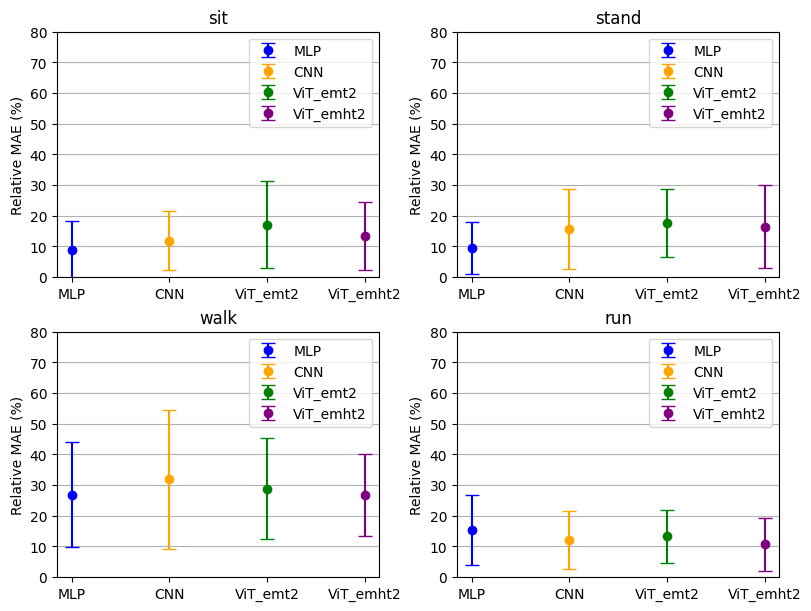

In [11]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)